# 12-Class SSVEP EEG Dataset - Classification Using Convolutional Neural Network
User-Dependent Training using Magnitude Spectrum Features and Complex Spectrum Features
(10-Fold Cross-validation)

Following implementation is an asynchronous SSVEP BCI using Convolutional Neural Network classification for 1 second data length.

Reference Paper: [Comparing user-dependent and user-independent training of CNN for SSVEP BCI](https://iopscience.iop.org/article/10.1088/1741-2552/ab6a67)


In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%config Completer.use_jedi = False

In [2]:
%%capture
import warnings
import numpy as np
import numpy.matlib as npm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle
from sklearn.model_selection import KFold

from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.losses import categorical_crossentropy

from bcilib.ssvep_utils_pytorch import CNN
from bcilib import ssvep_utils as su
from torch.utils.data import TensorDataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

warnings.filterwarnings('ignore')

In [3]:
model = CNN()
from torchsummary import summary
summary(model.network.cuda(), (8, 220, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 213, 1]           1,024
       BatchNorm2d-2           [-1, 16, 213, 1]              32
              ReLU-3           [-1, 16, 213, 1]               0
           Dropout-4           [-1, 16, 213, 1]               0
            Conv2d-5           [-1, 16, 204, 1]           2,560
       BatchNorm2d-6           [-1, 16, 204, 1]              32
              ReLU-7           [-1, 16, 204, 1]               0
           Dropout-8           [-1, 16, 204, 1]               0
           Flatten-9                 [-1, 3264]               0
           Linear-10                   [-1, 12]          39,168
Total params: 42,816
Trainable params: 42,816
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 0.16
Estimated Tot

In [4]:
def get_training_data(features_data):
    features_data = np.reshape(features_data, (features_data.shape[0], features_data.shape[1], 
                                               features_data.shape[2], 
                                               features_data.shape[3]*features_data.shape[4]))
    train_data = features_data[:, :, 0, :].T
    for target in range(1, features_data.shape[2]):
        train_data = np.vstack([train_data, np.squeeze(features_data[:, :, target, :]).T])

    train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 
                                         train_data.shape[2], 1))
    total_epochs_per_class = features_data.shape[3]
    features_data = []
    class_labels = np.arange(CNN_PARAMS['num_classes'])
    labels = (npm.repmat(class_labels, total_epochs_per_class, 1).T).ravel()
    labels = to_categorical(labels)
    
    return train_data, labels

In [5]:
def train_CNN_cross_val_predict(train_data, labels, num_folds=10):
    print("INPUT SHAPE: ", train_data.shape)
    
    labels = np.argmax(labels, axis=1)
    print("LABEL SHAPE: ", labels.shape)
    
    # frame_dataset = ShapesNpzDataset("/home/nogay/Desktop/frame_dataset/dataset.npz", target_transform=int)
    train_size = int(0.6 * len(train_data))
    val_size = int(0.2 * len(train_data))
    test_size = len(train_data) - train_size - val_size
    print(train_size, val_size, test_size)
    
    
    tensor_x = torch.from_numpy(train_data) # transform to torch tensor
    tensor_y = torch.from_numpy(labels.astype(int))
    
    print(tensor_x.dtype)
    print(tensor_y.dtype)

    dataset = TensorDataset(tensor_x, tensor_y) # create your datset
    
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    dataloader_train = DataLoader(train_dataset, shuffle=True, num_workers=4, batch_size=16)
    dataloader_val = DataLoader(val_dataset, shuffle=False, num_workers=4, batch_size=16)
    dataloader_test = DataLoader(test_dataset, shuffle=False, num_workers=4, batch_size=16)
    
    early_stopping = EarlyStopping('val_loss', patience=10, mode='min')
    trainer = pl.Trainer(gpus=1, 
                         max_epochs=200, 
                         enable_pl_optimizer=True,
                         callbacks=[early_stopping])
    
    trainer.fit(model, dataloader_train, val_dataloaders=dataloader_val)
    return trainer.test(model, test_dataloaders=dataloader_test, ckpt_path=None)
    #return cv_acc

In [6]:
data_path = os.path.abspath('data')

CNN_PARAMS = {
    'batch_size': 64,
    'epochs': 50,
    'droprate': 0.25,
    'learning_rate': 0.001,
    'lr_decay': 0.0,
    'l2_lambda': 0.0001,
    'momentum': 0.9,
    'kernel_f': 10,
    'n_ch': 8,
    'num_classes': 12}

FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 3.0,
    'end_frequency': 35.0,
    'sampling_rate': 256
}

window_len = 1
shift_len = 1
    
all_acc = np.zeros((10, 1))

magnitude_spectrum_features = dict()
complex_spectrum_features = dict()

In [7]:
mcnn_training_data = dict()
ccnn_training_data = dict()

In [8]:
mcnn_results = dict()
ccnn_results = dict()

# Load Dataset and Segment

In [9]:
all_segmented_data = dict()
for subject in range(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    
    CNN_PARAMS['num_classes'] = eeg.shape[0]
    CNN_PARAMS['n_ch'] = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    sample_rate = 256

    filtered_data = su.get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    all_segmented_data[f's{subject+1}'] = su.get_segmented_epochs(filtered_data, window_len, 
                                                                  shift_len, sample_rate)

# Feature Extraction

In [10]:
for subject in all_segmented_data.keys():
    magnitude_spectrum_features[subject] = su.magnitude_spectrum_features(all_segmented_data[subject], 
                                                                          FFT_PARAMS)
    complex_spectrum_features[subject] = su.complex_spectrum_features(all_segmented_data[subject], 
                                                                      FFT_PARAMS)

In [11]:
for subject in all_segmented_data.keys():
    mcnn_training_data[subject] = dict()
    ccnn_training_data[subject] = dict()
    train_data, labels = get_training_data(magnitude_spectrum_features[subject])
    mcnn_training_data[subject]['train_data'] = train_data
    mcnn_training_data[subject]['label'] = labels
    
    train_data, labels = get_training_data(complex_spectrum_features[subject])
    ccnn_training_data[subject]['train_data'] = train_data
    ccnn_training_data[subject]['label'] = labels

# M-CNN Training and Results

In [12]:
# acc_list = []

# for subject in mcnn_training_data.keys():
#     print(f'\nMCNN - Subject: {subject}')
#     train_data = mcnn_training_data[subject]['train_data']
#     labels = mcnn_training_data[subject]['label']
    
#     acc_list.append(train_CNN_cross_val_predict(train_data, labels, 10))

In [13]:
# l = 0
# for t in acc_list:
#     l += t[0]["test_acc"]
# print(l/len(acc_list))

# C-CNN Training and Results

In [14]:
c_acc_list = []

for subject in ccnn_training_data.keys():
    print(f'\nCCNN - Subject: {subject}')
    train_data = ccnn_training_data[subject]['train_data']
    labels = ccnn_training_data[subject]['label']
    
    c_acc_list.append(train_CNN_cross_val_predict(train_data, labels, 10))



CCNN - Subject: s1
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5069444444444444, 'test_loss': 1.6326290369033813}
--------------------------------------------------------------------------------

CCNN - Subject: s2
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.4236111111111111, 'test_loss': 2.3508012294769287}
--------------------------------------------------------------------------------

CCNN - Subject: s3
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8472222222222222, 'test_loss': 0.47242987155914307}
--------------------------------------------------------------------------------

CCNN - Subject: s4
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9305555555555556, 'test_loss': 0.18026810884475708}
--------------------------------------------------------------------------------

CCNN - Subject: s5
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9722222222222222, 'test_loss': 0.06321574747562408}
--------------------------------------------------------------------------------

CCNN - Subject: s6
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9930555555555556, 'test_loss': 0.010945466347038746}
--------------------------------------------------------------------------------

CCNN - Subject: s7
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9236111111111112, 'test_loss': 0.2679435610771179}
--------------------------------------------------------------------------------

CCNN - Subject: s8
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9861111111111112, 'test_loss': 0.09112527966499329}
--------------------------------------------------------------------------------

CCNN - Subject: s9
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9722222222222222, 'test_loss': 0.22472983598709106}
--------------------------------------------------------------------------------

CCNN - Subject: s10
INPUT SHAPE:  (720, 8, 220, 1)
LABEL SHAPE:  (720,)
432 144 144
torch.float64
torch.int64



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8888888888888888, 'test_loss': 0.4793854355812073}
--------------------------------------------------------------------------------


In [15]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [16]:
l = 0
for t in c_acc_list:
    l += t[0]["test_acc"]
print(l/len(c_acc_list))

0.8444444444444443


# Summary

In [17]:
results = pd.DataFrame({'mcnn': np.fromiter(mcnn_results.values(), dtype=float), 
              'ccnn': np.fromiter(ccnn_results.values(), dtype=float)})

In [18]:
print(results)

Empty DataFrame
Columns: [mcnn, ccnn]
Index: []


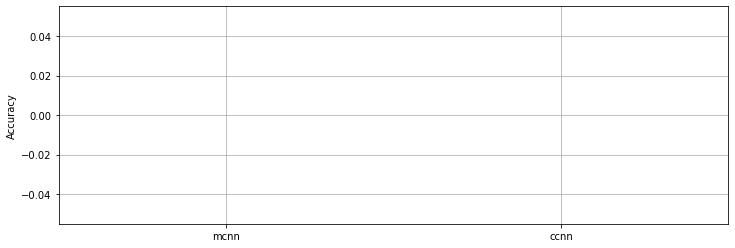

In [19]:
results.boxplot(figsize=(12, 4), column=['mcnn', 'ccnn'])
plt.ylabel('Accuracy')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

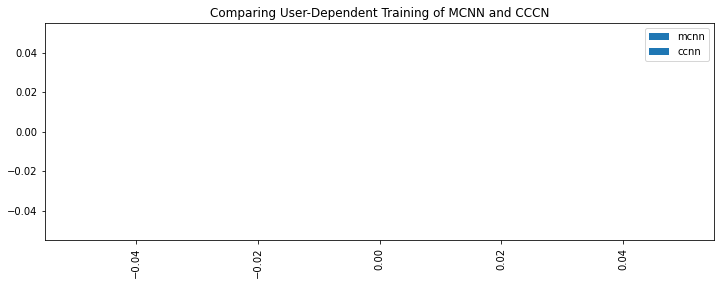

In [20]:
results.plot.bar(figsize=(12, 4), title='Comparing User-Dependent Training of MCNN and CCCN')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.show()